In [1]:
import pandas as pd
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score



In [15]:
# Load the crime dataset and remove crimes that are not of immediate interest
crime_df = pd.read_csv("/Users/someshsahu/Documents/DSAICSV/crimes.csv")

crime_counts = crime_df['OFNS_DESC'].value_counts()
filtered_df = crime_df[crime_df['OFNS_DESC'].isin(crime_counts[crime_counts > 1000].index)]



removed_filtered_df = filtered_df.drop(filtered_df[filtered_df['OFNS_DESC'].isin(['VOIDED ARRESTS', 'OTHER STATE LAWS', 'FORGERY', 'FRAUDS', 'OFFENSES INVOLVING FRAUD', 'INTOXICATED & IMPAIRED DRIVING', 'OTHER TRAFFIC INFRACTION', 'INTOXICATED/IMPAIRED DRIVING', 'GAMBLING', 'THEFT-FRAUD', 'MOVING INFRACTIONS', 'ADMINISTRATIVE CODE', 'OTHER STATE LAWS (NON PENAL LA'])].index)
removed_filtered_df.columns
# new_df = removed_filtered_df.iloc[0:100]


Index(['ARREST_KEY', 'ARREST_DATE', 'PD_CD', 'PD_DESC', 'KY_CD', 'OFNS_DESC',
       'LAW_CODE', 'LAW_CAT_CD', 'ARREST_BORO', 'ARREST_PRECINCT',
       'JURISDICTION_CODE', 'AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'X_COORD_CD',
       'Y_COORD_CD', 'Latitude', 'Longitude'],
      dtype='object')

The code below provides us with the top 3 precincts in terms of average number of crimes in a given month

In [16]:


removed_filtered_df['ARREST_DATE'] = pd.to_datetime(removed_filtered_df['ARREST_DATE'], format='%m/%d/%Y')
removed_filtered_df['year_month'] = removed_filtered_df['ARREST_DATE'].dt.to_period('M')
arrests_by_precinct = removed_filtered_df.groupby(['ARREST_PRECINCT', 'year_month']).size().reset_index(name='arrest_count')

# loop through each period and identify the top 3 precincts with the highest crime rates
top_precincts = pd.DataFrame(columns=['year_month', 'top_precincts'])
for period in arrests_by_precinct['year_month'].unique():
    period_data = arrests_by_precinct[arrests_by_precinct['year_month'] == period]
    period_data['avg_arrests'] = period_data['arrest_count'].mean()
    precincts = period_data.sort_values(by=['arrest_count'], ascending=False)['ARREST_PRECINCT'][:3]
    top_precincts = top_precincts.append({'year_month': period, 'top_precincts': precincts.tolist()}, ignore_index=True)

# output the top precincts for each period
print(top_precincts)

<ipython-input-16-dd3a93c52ef6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  period_data['avg_arrests'] = period_data['arrest_count'].mean()


   year_month top_precincts
0     2013-01  [75, 14, 40]
1     2013-02  [75, 14, 44]
2     2013-03  [75, 14, 40]
3     2013-04  [75, 44, 14]
4     2013-05  [75, 44, 14]
5     2013-06  [75, 44, 14]
6     2013-07  [75, 14, 44]
7     2013-08  [75, 44, 14]
8     2013-09  [75, 14, 44]
9     2013-10  [75, 14, 40]
10    2013-11  [75, 14, 40]
11    2013-12  [14, 75, 40]
12    2014-01  [14, 40, 75]
13    2014-02  [14, 75, 25]
14    2014-03  [75, 14, 40]
15    2014-04  [75, 14, 40]
16    2014-05  [75, 14, 40]
17    2014-06  [14, 75, 40]
18    2014-07  [14, 75, 40]
19    2014-08  [40, 75, 14]
20    2014-09  [75, 14, 40]
21    2014-10  [14, 75, 40]
22    2014-11  [14, 40, 75]
23    2014-12  [14, 40, 75]
24    2015-01  [14, 40, 44]
25    2015-02  [14, 40, 75]
26    2015-03  [40, 14, 75]
27    2015-04  [14, 75, 40]
28    2015-05  [75, 40, 44]
29    2015-06  [75, 40, 14]
30    2015-07  [75, 40, 14]
31    2015-08  [75, 40, 44]
32    2015-09  [40, 75, 44]
33    2015-10  [40, 14, 75]
34    2015-11  [40, 

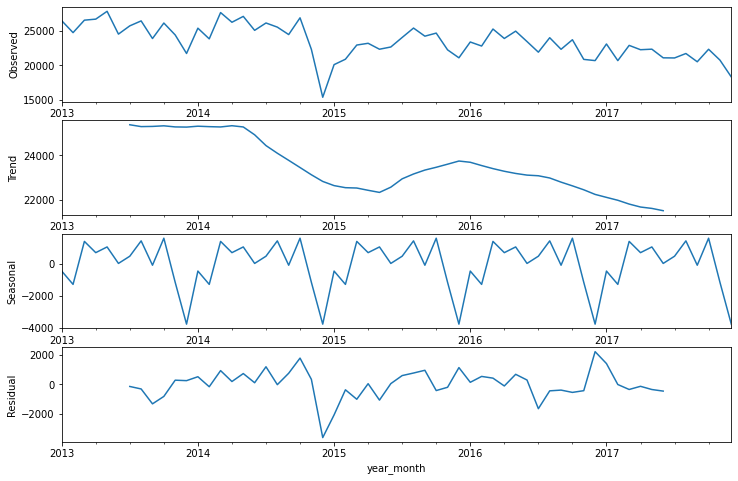

In [17]:
# group the data by period of time and calculate the total number of arrests in each group
removed_filtered_df['ARREST_DATE'] = pd.to_datetime(removed_filtered_df['ARREST_DATE'], format='%m/%d/%Y')
removed_filtered_df['year_month'] = removed_filtered_df['ARREST_DATE'].dt.to_period('M')
arrests_by_period = removed_filtered_df.groupby(['year_month']).size().reset_index(name='arrest_count')

# perform time series analysis
arrests_by_period.set_index('year_month', inplace=True)
arrests_by_period.index = pd.to_datetime(arrests_by_period.index.to_timestamp())
decomposition = sm.tsa.seasonal_decompose(arrests_by_period['arrest_count'], model='additive', period=12)

# plot the results of the time series analysis
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))
decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
plt.show()

In [ ]:

# Create a subset of the data with relevant features
arrests_subset = arrests_df[['ARREST_PRECINCT', 'year_month', 'num_arrests']]

# Create a pivot table to aggregate the data by precinct and period of time
arrests_pivot = pd.pivot_table(arrests_subset, values='num_arrests', index=['ARREST_PRECINCT'], columns=['year_month'])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(arrests_pivot.dropna().drop(['top_3'], axis=1), arrests_pivot.dropna()['top_3'], test_size=0.2, random_state=42)

# Train a decision tree regression model
model = DecisionTreeRegressor(random_state=42)
model.fit(X_train, y_train)

# Evaluate the performance of the model on the testing set
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


In [ ]:
street_map = gpd.read_file('/Users/someshsahu/Downloads/Shapefiles and base map/geo_export_e32126a9-4611-4f2e-a62d-d39fdd22619e.shp')
street_map.to_crs(4326)


In [ ]:
geometry21 = [Point(xy) for xy in zip(new_df['Longitude'], new_df['Latitude'])]
geo_df21 = gpd.GeoDataFrame(new_df, crs="EPSG:4326", geometry=geometry21)
geo_df21

#plot both streetmap and and long/lat points
fig, ax = plt.subplots(figsize=(15,15))
geo_df21.plot(column="OFNS_DESC", ax=ax,alpha=0.5, legend=True,markersize=30)
street_map.to_crs(4326).plot(ax=ax, alpha=0.4,color='grey')
# add title to graph
plt.title('Crime in NYC', fontsize=15,fontweight='bold')
# set latitiude and longitude boundaries for map display
plt.xlim(-74.3, -73.7)
plt.ylim(40.5, 40.95)
plt.show()